In [1]:
#importing libraries
from fastai import *
#from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path

In [2]:
!git clone https://github.com/joerivc/MasterThesis.git


Cloning into 'MasterThesis'...
remote: Enumerating objects: 6771, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6771 (delta 4), reused 0 (delta 0), pack-reused 6762
Receiving objects: 100% (6771/6771), 1.21 GiB | 14.39 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Updating files: 100% (40438/40438), done.


In [3]:
x  = '/content/MasterThesis/Images6ClassesPerPerson'
path = Path(x)
path.ls()

(#3) [Path('/content/MasterThesis/Images6ClassesPerPerson/val'),Path('/content/MasterThesis/Images6ClassesPerPerson/test'),Path('/content/MasterThesis/Images6ClassesPerPerson/train')]

In [4]:
data = ImageDataLoaders.from_folder(path, train='train', valid='val',
                                    item_tfms=Resize(460),
                                    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)],
                                    num_workers=4)

In [ ]:
np.random.seed(40)
# Determine the aspect ratio of your images (720x480)
aspect_ratio = 720 / 480

# Choose a target width or height that maintains the aspect ratio
target_width = 224
target_height = int(target_width / aspect_ratio)  # Calculate height based on aspect ratio
data = ImageDataLoaders.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=aug_transforms(), size=(480, 240),
                                  num_workers=4)#.normalize(imagenet_stats)

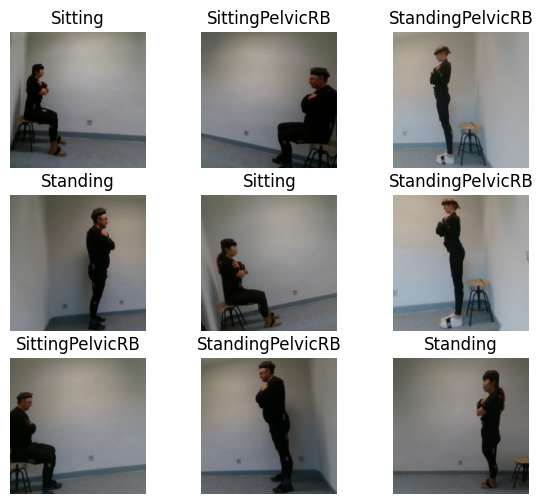

In [5]:
data.show_batch(figsize=(7,6))

In [6]:
learn = vision_learner(data, models.vgg16, metrics=[accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 182MB/s]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0005754399462603033)

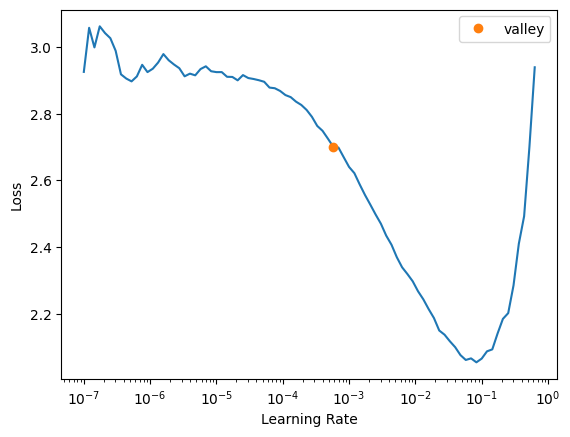

In [7]:
learn.lr_find()
#learn.recorder.plot(suggestions=True)

In [8]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(40,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,1.698086,2.560403,0.412500,00:09
1,1.358257,1.572125,0.377083,00:09
2,1.259221,3.167030,0.300000,00:09
3,1.310448,3.882095,0.256250,00:09
4,1.468951,4.819466,0.227083,00:09
5,1.425289,2.170508,0.383333,00:09
6,1.296044,2.959584,0.366667,00:09
7,1.270264,2.742817,0.331250,00:09
8,1.354712,3.620259,0.279167,00:09
9,1.487558,3.780498,0.352083,00:09


In [9]:
learn.unfreeze()
learn.fit_one_cycle(20,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.551112,2.034962,0.356250,00:15
1,0.517825,1.857191,0.370833,00:15
2,0.465205,2.444556,0.410417,00:15
3,0.414641,1.643503,0.366667,00:15
4,0.359236,1.563091,0.441667,00:15
5,0.310835,2.405549,0.418750,00:15
6,0.265845,2.106749,0.391667,00:15
7,0.233807,1.686811,0.502083,00:15
8,0.204742,2.202650,0.468750,00:15
9,0.179953,1.980769,0.460417,00:15


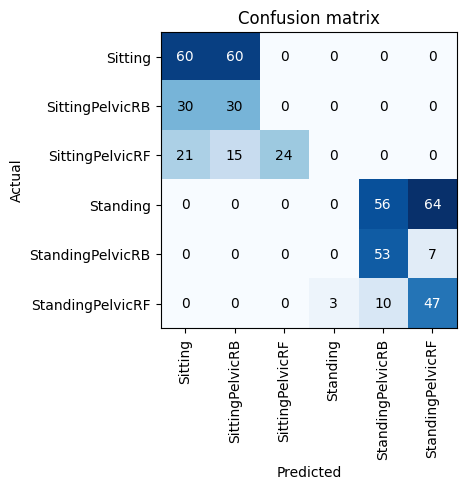

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#from fastai.vision import open_image
from fastai.vision.all import *
from fastai.vision import models


In [ ]:
#img = open_image('/content/testImages/Sitting08004.png')
img = PILImage.create('/content/testImages/Sitting08004.png')
print(learn.predict(img)[0])

Sitting


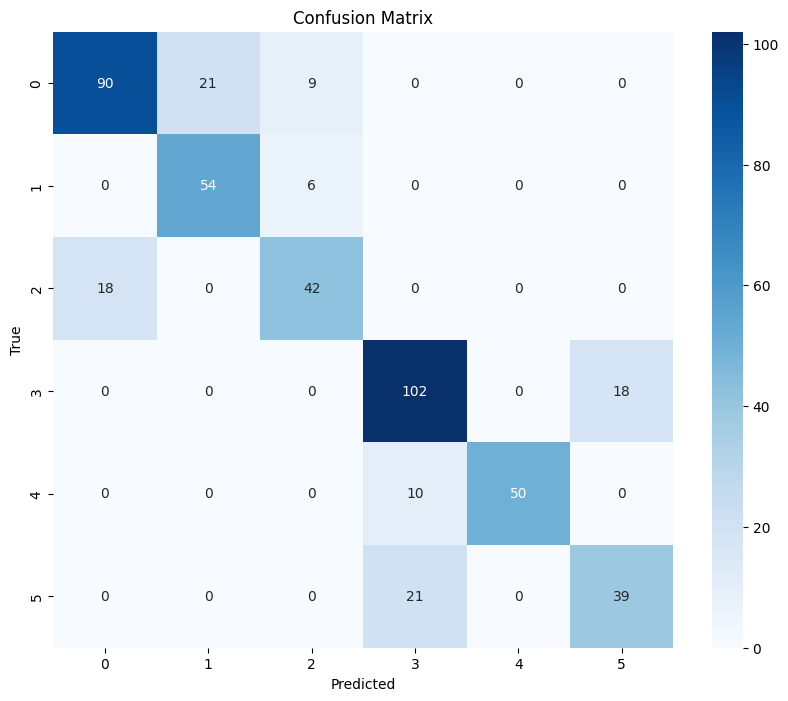

In [11]:
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix
import os

# Assuming 'learn' is your Learner object
#learn = load_learner('path_to_saved_model.pkl')

# Path to your testing images folder
test_folder_path = '/content/MasterThesis/Images6ClassesPerPerson/test'

# List to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over each subdirectory in the testing folder
for class_name in os.listdir(test_folder_path):
    class_path = os.path.join(test_folder_path, class_name)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Iterate over each image in the subdirectory
        for img_name in os.listdir(class_path):
            # Create a PILImage object from the image file
            img = PILImage.create(os.path.join(class_path, img_name))

            # Make a prediction using the learner
            pred, _, _ = learn.predict(img)

            # Append the predicted label and true label
            predicted_labels.append(str(pred))
            true_labels.append(class_name)  # Use the subdirectory name as the true label

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()